# Goes through all simulations and print statistics

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mtplc
import pandas as pd
import numpy as np
import tomli
import tqdm
import pickle, gzip
import seaborn as sns

from qutip import Qobj
import qutip as qt

from pathlib import Path

ROOT = Path('simulations')

OBSERVABLES = [
    "energy"
]
VARIABLE_COLUMNS = [
    ("phaseonium", "phi_hot"),
    ("phaseonium", "phi_cold"),
    ("cavity1", "expanding_force"),
    ("cavity1", "compressing_force"),
    ("cavity2", "expanding_force"),
    ("cavity2", "compressing_force"),
    ("stroke_time", "isochore"),
]
OMEGA = 5.0
T_HOT = 2.5
T_COLD = 1.0

REGENERATE = True

# Colors for the strokes
CS1 = "#454545"
CS2 = "#888888"

ledger = pd.read_csv(ROOT / 'simulations_ledger.csv', header=[0, 1])
ledger["Error"] = [0 for _ in range(len(ledger))]
ledger.set_index(("meta", "name"), inplace=True)
print(f"There are {len(ledger)} simulations in the ledger")

There are 1223 simulations in the ledger


In [2]:
def assign_forces(config, strokes, sampling_times):
    f1_exp = config["cavity1"]["expanding_force"]
    f1_comp = config["cavity1"]["compressing_force"]
    f2_exp = config["cavity2"]["expanding_force"]
    f2_comp = config["cavity2"]["compressing_force"]
    forces1 = []
    forces2 = []
    for t in sampling_times:
        if t < strokes[0][1]:
            forces1.append(0)
            forces2.append(0)
        elif t < strokes[1][1]:
            forces1.append(f1_exp)
            forces2.append(f2_exp)
        elif t < strokes[2][1]:
            forces1.append(0)
            forces2.append(0)
        elif t < strokes[3][1]:
            forces1.append(f1_comp)
            forces2.append(f2_comp)
        else:
            forces1.append(0)
            forces2.append(0)

    return np.array(forces1), np.array(forces2)


def read_configuration(filepath, system_evolution_times):

    with open(filepath / "config.toml", "rb") as config_file:
            config = tomli.load(config_file)

    ndims = int(config["meta"]["dims"])
    dt = config["meta"]["dt"]
    alpha = config["cavity1"]["alpha"]
    surfaces = (config["cavity1"]["surface"], config["cavity2"]["surface"])

    isochore_steps = config["stroke_time"]["isochore"]
    isochore_samplings = config["samplings"]["isochore"]
    adiabatic_samplings = config["samplings"]["adiabatic"]

    cycle_steps = np.cumsum(np.load(filepath / "cycle_steps.npy"))  # Duration of each step
    strokes = [
        (0, cycle_steps[0]),
        (cycle_steps[0] + dt, cycle_steps[1]),
        (cycle_steps[1] + dt, cycle_steps[2]),
        (cycle_steps[2] + dt, cycle_steps[3]),
    ]
    
    samplings = sorted(system_evolution_times, key=lambda x: int(x))

    # Take the left-hand side of each interval
    sampling_times = np.array([
        *np.linspace(*strokes[0], isochore_samplings),
        *np.linspace(*strokes[1], adiabatic_samplings),
        *np.linspace(*strokes[2], isochore_samplings),
        *np.linspace(*strokes[3], adiabatic_samplings)
    ]).flatten()

    forces = assign_forces(config, strokes, sampling_times)
    sampling_times_dict = {v: int(k) for k, v in zip(samplings, sampling_times)}

    return ndims, alpha, surfaces, forces, sampling_times, strokes


def create_evolution_dict():
    dict = {
        "S":{
            "State": [],
            "Hamiltonian": [],
            "Energy": [],
            "Entropy": [],
            "Mutual Information": [],
            "Work": {
                "Alicki": [],
                "Classic": [],
            },
            "Heat": [],
        },
        "S1": {
            "State": [],
            "Frequency": [],
            "Hamiltonian": [],
            "Energy": [],
            "Entropy": [],
            "Work": {
                "Alicki": [],
                "Pressure": [],
                "Classic": [],
            },
            "Heat": [],
        },
        "S2": {
            "State": [],
            "Frequency": [],
            "Hamiltonian": [],
            "Energy": [],
            "Entropy": [],
            "Work": {
                "Alicki": [],
                "Pressure": [],
                "Classic": [],
            },
            "Heat": [],
        },
    }
    return dict


def avg_energy(s:Qobj, h:Qobj) -> float:
    return (s * h).tr()


## Work and Heat

In [3]:
# Calculate work and heat by Alicki's definition
def alicki_definition(rho, rho_previous, h, h_previous):
    if rho_previous is None:
        return (0, 0)
    
    # Energy changes between steps
    energy = (rho * h).tr()
    energy_previous = (rho_previous * h_previous).tr()
    delta_energy = energy - energy_previous
    
    # Calculate adiabatic energy changes (work)
    # This requires calculating energy expectation of previous density matrix with current Hamiltonian
    adiabatic_energy = (rho_previous * h).tr()
    work = np.real(adiabatic_energy - energy_previous)

    # Heat is the remaining energy change
    heat = np.real(delta_energy - work)
    
    return work, heat


def calc_pressure_op(ndims, alpha, l, s, t):
    idd = Qobj(np.diag(np.ones(ndims)))  # Identity matrix
    n = Qobj(np.diag(np.arange(1, ndims + 1)))
    a = qt.destroy(ndims)
    ad = a.dag()

    f = alpha / l

    pressure_op = (2*n + idd)
    pressure_op -= (a * a * np.exp(-1j*2*f*t)) 
    pressure_op -= (ad * ad * np.exp(1j*2*f*t))

    return alpha / (2 * l**2 * s) * pressure_op


def pressure_work(rho, rho_previous, l, l_previous, t, ndims, alpha, s):
    if rho_previous is None:
        return (0, 0)
    
    delta_l = l - l_previous
    
    pressure_op = calc_pressure_op(ndims, alpha, l, s, t)

    pressure = qt.expect(pressure_op, rho)

    work = pressure * s * delta_l

    return work


# Compute work via the external force applied to the moving mirror
def classical_work(force, l, l_previous):
    # Calculate the movement of the cavity
    delta_l = l - l_previous

    work = force * delta_l

    return work



## Plot Functions

In [4]:
def plot_observable(x, y, stroke_times=None, ymin=None, ymax=None, label=None, ax=None, title=None, grid=False):
    if not ax:
        fig, ax = plt.subplots(figsize=(8, 4))
        fig.suptitle(title)

        if grid:
            ax.grid(linestyle="--", alpha=0.2)
        
        if not ymin:
            ymin = min(y) - 0.2*min(y) if min(y) > 0 else min(y) + 0.2*min(y)
        ymax = max(y) + 0.2*max(y) if not ymax else ymax
        plot_stroke_overlays(ax, ymin, ymax, stroke_times)
        return_obj = (fig, ax)
    else:
        ax.set_title(title)
        return_obj = None
        
    ax.plot(x, y, label=label)
    if label:
        ax.legend()
        
    return return_obj


def plot_stroke_overlays(ax, ymin, ymax, stroke_times):
    ax.fill_betweenx([ymin, ymax], *stroke_times[0], alpha=0.1, fc='r')
    ax.fill_betweenx([ymin, ymax], *stroke_times[2], alpha=0.1, fc='b')


def plot_evolution(name, observables, sampling_times, stroke_times, show=False, filepath=None):
    if name == "Entropy":
        ys = [
            observables["S"]["Entropy"],
            observables["S1"]["Entropy"],
            observables["S2"]["Entropy"],
        ]
        label = "S"
    elif name == "Mutual Information":
        ys = [
            observables["S"]["Mutual Information"]
        ]
        label = "I"
    elif name == "Alicki's Work":
        ys = [
            observables["S"]["Work"]["Alicki"],
            observables["S1"]["Work"]["Alicki"],
            observables["S2"]["Work"]["Alicki"],
        ]
        label = "W"
    elif name == "Heat":
        ys = [
            observables["S"]["Heat"],
            observables["S1"]["Heat"],
            observables["S2"]["Heat"],
        ]
        label = "Q"
    else:
        raise ValueError(f"Observable {name} not known.")

    fig, ax = plot_observable(sampling_times, ys[0], stroke_times=stroke_times, label=f"{label}AB")
    if len(ys) > 1:
        for y, s in zip(ys, ['A', 'B']):
            plot_observable(sampling_times, y, label=f"{label}{s}", ax=ax)

    ax.set_title(name)

    if filepath is not None:
        filename = name.lower().replace("'", "").replace(" ", "_")
        fig.savefig(filepath / f"visualization/{filename}.png")
        fig.savefig(filepath / f"visualization/{filename}.pdf")
    
    if show:
        plt.show()
    else:
        plt.close()

    return None


def plot_f_E_cycle(ax, frequencies, energies):
    f1, f2 = frequencies
    energy1, energy2 = energies
    ax.plot(f1, energy1, label="$S1$", c=CS1)
    ax.plot(f2, energy2, label="$S2$", c=CS2, ls="--")
    ax.text(0.495, 0.49, u'\u27f2', horizontalalignment='center', alpha=0.1, color=CS2,
        verticalalignment='center', transform=ax.transAxes, fontsize=60)
    ax.text(0.505, 0.51, u'\u27f2', horizontalalignment='center', alpha=0.1, color=CS1,
        verticalalignment='center', transform=ax.transAxes, fontsize=60)
    
    # Create the strokes overlays
    ymax = max(max(energy1), max(energy2)) + 0.1*max(max(energy1), max(energy2))
    ymin = min(min(energy1), min(energy2)) - 0.1*min(min(energy1), min(energy2))
    # Heating stroke at maximum frequency
    x_heating = max(max(f1), max(f2))
    dx_h = 0.0001 * x_heating
    # Cooling stroke at minimum frequency
    x_cooling = min(min(f1), min(f2))
    dx_c = 0.0001 * x_cooling
    ax.fill_between([x_cooling - dx_c, x_cooling + dx_c], ymin, ymax, alpha=0.2, fc='b', label="Cooling")
    ax.fill_between([x_heating - dx_h, x_heating + dx_h], ymin, ymax, alpha=0.2, fc='r', label="Heating")


def plot_obs_evolution(ax, observables, name, sampling_times, stroke_times):
    y1, y2 = observables
    ax.set_title(name)
    ax.plot(sampling_times, y1, c=CS1)
    ax.plot(sampling_times, y2, c=CS2, ls="--")
    ax.fill_between(stroke_times[0], min(y1), max(y1), alpha=0.1, fc='r')
    ax.fill_between(stroke_times[2], min(y1), max(y1), alpha=0.1, fc='b')
    

def plot_cycles(observables, sampling_times, stroke_times, ax=None, show=True, filepath=None):
    f1 = observables["S1"]["Frequency"]
    f2 = observables["S2"]["Frequency"]
    energy1 = observables["S1"]["Energy"]
    energy2 = observables["S2"]["Energy"]
    
    if ax is not None:
        plot_f_E_cycle(ax, (f1, f2), (energy1, energy2))    
        ax.grid(alpha=0.2, linestyle='--')  
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(3, layout="constrained", figsize=(8, 10))
        fig.suptitle("Cavities Cycles")
        plot_f_E_cycle(ax1, (f1, f2), (energy1, energy2))
        plot_obs_evolution(ax2, (f1, f2), "Frequencies", sampling_times, stroke_times)
        plot_obs_evolution(ax3, (energy1, energy2), "Energies", sampling_times, stroke_times)

        # Place the legend on top of the figure
        fig.legend(bbox_to_anchor=(0., 1., 1.05, 0.04), loc=2, ncol=4, mode="expand")
        # Add the grids
        for ax in (ax1, ax2, ax3):
            ax.grid(alpha=0.2, linestyle='--')  

    if filepath is not None:        
        fig.savefig(filepath / "visualization/cycle_dynamics.png")
        fig.savefig(filepath / "visualization/cycle_dynamics.pdf")
    
    if show:
        plt.show()
    else:
        plt.close()

    return None



## Extract Good Simulations

In [5]:
def extract_simulation_data(file, plots=False):
        
    system_evolution = np.load(file / "cascade_evolution_1cycle.npz")
    cavities_evolution = np.load(file / "cavities_evolution_1cycle.npz")
    
    evolution_history = create_evolution_dict()
    ndims, alpha, surfaces, forces, sampling_times, stroke_times = read_configuration(file, system_evolution.files)    # Evolution of the multipartite system in terms of Qobj
    surf1, surf2 = surfaces
    forces1, forces2 = forces
    print(len(forces1), end=', ')
    print(len(forces2), end=' - ')
    print(len(sampling_times))
    s_evolution = []
    rho_previous = rho1_previous = rho2_previous = None
    h_previous = h1_previous = h2_previous = None
    l1_previous = alpha / cavities_evolution["c1"][0]
    l2_previous = alpha / cavities_evolution["c2"][0]
    
    for i, t in enumerate(tqdm.tqdm(sampling_times, desc=f"Extracting data from {file.name}")):
        rho = Qobj(system_evolution[str(i + 1)], dims=[[ndims, ndims], [ndims, ndims]])
        s1:Qobj = rho.ptrace(1)
        s2:Qobj = rho.ptrace(0)
        evolution_history["S"]["State"].append(rho)
        evolution_history["S1"]["State"].append(s1)
        evolution_history["S2"]["State"].append(s2)

        f1:float = cavities_evolution["c1"][i]
        l1 = alpha / f1
        f2:float = cavities_evolution["c2"][i]
        l2 = alpha / f2
        evolution_history["S1"]["Frequency"].append(f1)
        evolution_history["S2"]["Frequency"].append(f2)

        # Hamiltonian
        h1 = Qobj(f1 * np.diag(np.arange(1, ndims + 1)))
        h2 = Qobj(f2 * np.diag(np.arange(1, ndims + 1)))
        h = qt.tensor(h1, h2)
        evolution_history["S"]["Hamiltonian"].append(h)
        evolution_history["S1"]["Hamiltonian"].append(h1)
        evolution_history["S2"]["Hamiltonian"].append(h2)
        
        # Observables
        evolution_history["S"]["Energy"].append(avg_energy(rho, h))
        evolution_history["S1"]["Energy"].append(avg_energy(s1, h1))
        evolution_history["S2"]["Energy"].append(avg_energy(s2, h2))
        evolution_history["S"]["Entropy"].append(qt.entropy_vn(rho))
        evolution_history["S1"]["Entropy"].append(qt.entropy_vn(s1))
        evolution_history["S2"]["Entropy"].append(qt.entropy_vn(s2))
        evolution_history["S"]["Mutual Information"].append(qt.entropy_mutual(rho, 0, 1))

        # Work and Heat
        alicki_work, alicki_heat = alicki_definition(rho, rho_previous, h, h_previous)
        alicki_work1, alicki_heat1 = alicki_definition(s1, rho1_previous, h1, h1_previous)
        alicki_work2, alicki_heat2 = alicki_definition(s2, rho2_previous, h2, h2_previous)
        evolution_history["S"]["Work"]["Alicki"].append(alicki_work)
        evolution_history["S"]["Heat"].append(alicki_heat)
        evolution_history["S1"]["Work"]["Alicki"].append(alicki_work1)
        evolution_history["S1"]["Work"]["Pressure"].append(pressure_work(s1, rho1_previous, l1, l1_previous, t, ndims, alpha, surf1))
        evolution_history["S1"]["Work"]["Classic"].append(classical_work(forces1[i], l1, l1_previous))
        evolution_history["S1"]["Heat"].append(alicki_heat1)
        evolution_history["S2"]["Work"]["Alicki"].append(alicki_work2)
        evolution_history["S2"]["Work"]["Pressure"].append(pressure_work(s2, rho2_previous, l2, l2_previous, t, ndims, alpha, surf2))
        evolution_history["S2"]["Work"]["Classic"].append(classical_work(forces2[i], l2, l2_previous))
        evolution_history["S2"]["Heat"].append(alicki_heat2)

        rho_previous, rho1_previous, rho2_previous = rho, s1, s2
        l1_previous = l2_previous = l1, l2
        h_previous, h1_previous, h2_previous = h, h1, h2
    
    with gzip.open(file / "evolution_history.pkl.gz", "wb") as zipfile:
        pickle.dump(evolution_history, zipfile)

    if plots:
        plot_cycles(evolution_history, sampling_times, stroke_times, show=False, filepath=file)
        plot_evolution("Entropy", evolution_history, sampling_times, stroke_times, show=False, filepath=file)
        plot_evolution("Mutual Information", evolution_history, sampling_times, stroke_times, show=False, filepath=file)
        plot_evolution("Alicki's Work", evolution_history, sampling_times, stroke_times, show=False, filepath=file)
        plot_evolution("Heat", evolution_history, sampling_times, stroke_times, show=False, filepath=file)

In [6]:
simulation_folders = [ROOT / f"simulation_{n}" for n in ledger.index]
good_simulations = []
for f in simulation_folders:
    if not f.is_dir() or not (f / "cascade_evolution_1cycle.npz").exists():
        # Go to the next filename
        ledger.loc[f.name.replace("simulation_", "")]["Error"] = 1
        continue
    else:
        ledger.loc[f.name.replace("simulation_", "")]["Error"] = 0

    if REGENERATE and not (f / "evolution_history.pkl.gz").exists():
        print(f"Extracting from {f.name}")
        try:
            extract_simulation_data(f, plots=True)
        except FileNotFoundError as e:
            print(f"Simulation {f.name} failed with error: {e}")
            continue
    if (f / "evolution_history.pkl.gz").exists():
        good_simulations.append(f.name)

print(f"There are a total of {len(good_simulations)} finished simulations.")

/tmp/ipykernel_3842415/4168350323.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ledger.loc[f.name.replace("simulation_", "")]["Error"] = 1
/tmp/ipykernel_3842415/4168350323.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ledger.loc[f.name.replace("simulation_", "")]["Error"] = 0


There are a total of 357 finished simulations.


Some simulation was skipped but it's still needed.
To resume their calculations, we must remove the report.txt file

In [7]:
need_simulations = False  # Make this True to regenerate the simulations in Julia
if need_simulations:
    needed = ledger.loc[ledger[("stroke_time", "isochore")] == 1000000].index
    needed = [f"simulation_{n}" for n in needed if f"simulation_{n}" not in good_simulations]

    for f in needed:
        if not (ROOT / f).is_dir() or not (ROOT / f / "report.txt").exists():
            # Go to the next filename
            continue
        else:
            (ROOT / f / "report.txt").unlink()
  

In [8]:
df_simulations = ledger.loc[[s.replace("simulation_", "") for s in good_simulations], VARIABLE_COLUMNS]
df_simulations = df_simulations.sort_index(axis=0)
df_simulations = df_simulations.sort_index(axis=1)
df_simulations.head(10)

cavity1                           cavity2  \
             compressing_force expanding_force compressing_force   
(meta, name)                                                       
00c2a3f9-3                 2.0             2.0               1.8   
013e97fd-3                 2.0             2.0               1.9   
0170debc-4                 1.8             1.8               1.8   
01fee3cf-1                 1.9             1.9               1.8   
0573f77b-a                 1.9             1.9               1.8   
059d49fe-1                 1.8             1.8               1.9   
067a4fbc-4                 2.5             2.5               1.9   
068ae873-e                 2.5             2.5               1.8   
07f3d22b-8                 1.8             1.8               1.9   
083a6ca5-e                 2.5             2.5               1.9   

                             phaseonium         stroke_time  
             expanding_force   phi_cold phi_hot    isochore  
(meta, name)                                                 
00c2a3f9-3               1.8        2.2     1.6        5000  
013e97fd-3               1.9        2.7     1.3        3000  
0170debc-4               1.8        2.7     1.8        5000  
01fee3cf-1               1.8        2.7     1.3        5000  
0573f77b-a               1.8        2.2     1.8        3000  
059d49fe-1               1.9        2.7     1.3        2000  
067a4fbc-4               1.9        2.2     1.6        2000  
068ae873-e               1.8        2.4     1.6        5000  
07f3d22b-8               1.9        2.2     1.8        2000  
083a6ca5-e               1.9        2.7     1.8        5000

In [9]:
def classic_temp(quantum_temp, omega, phi):
    den = 1 - quantum_temp / omega * np.log(1 + np.cos(phi))
    return quantum_temp / den

work_outputs = []
heats_absorbed = []
efficiencies = []
carnot_efficiencies = []
cnca_efficiencies = []  # Chambadal–Novikov–Curzon–Ahlborn efficiency
T_hots = []
T_colds = []
for name, params in tqdm.tqdm(df_simulations.iterrows()):
    f = ROOT / f"simulation_{name}"
    with gzip.open(f / "evolution_history.pkl.gz", "rb") as zipfile:
        evolution_history = pickle.load(zipfile)

    work_output = -sum(evolution_history["S"]["Work"]["Alicki"])
    heat_absorbed = sum(q for q in evolution_history["S"]["Heat"] if q > 0)
    efficiency = work_output / heat_absorbed

    work_outputs.append(work_output)
    heats_absorbed.append(heat_absorbed)
    efficiencies.append(efficiency)
    T_hot_cl = classic_temp(T_HOT, OMEGA, np.pi / params[("phaseonium", "phi_hot")])
    T_cold_cl = classic_temp(T_COLD, OMEGA, np.pi / params[("phaseonium", "phi_cold")])
    T_hots.append(T_hot_cl)
    T_colds.append(T_cold_cl)
    carnot_efficiencies.append(1 - T_cold_cl / T_hot_cl)
    cnca_efficiencies.append(1 - np.sqrt(T_cold_cl / T_hot_cl))

    # Carnot efficiency
    phi_hot = params[("phaseonium", "phi_hot")]
    phi_cold = params[("phaseonium", "phi_cold")]

df_simulations.loc[:, ("temperature", "Classic Hot")] = T_hots
df_simulations.loc[:, ("temperature", "Quantum Hot")] = T_HOT
df_simulations.loc[:, ("temperature", "Classic Cold")] = T_colds
df_simulations.loc[:, ("temperature", "Quantum Cold")] = T_COLD
df_simulations.loc[:, ("output", "Work")] = work_outputs
df_simulations.loc[:, ("output", "Heat")] = heat_absorbed
df_simulations.loc[:, ("output", "Efficiency")] = efficiencies
df_simulations.loc[:, ("output", "Carnot")] = carnot_efficiencies
df_simulations.loc[:, ("output", "CNCA")] = cnca_efficiencies

357it [07:04,  1.19s/it]


In [10]:
df_simulations.loc[:, ("output", "Carnot")]

(meta, name)
00c2a3f9-3    0.489952
013e97fd-3    0.275586
0170debc-4    0.530523
01fee3cf-1    0.275586
0573f77b-a    0.549875
                ...   
fc3f2b53-2    0.549875
fca6c92c-0    0.468025
fd84a1ad-f    0.600000
ff9e226d-e    0.549875
ffd044ff-f    0.530523
Name: (output, Carnot), Length: 357, dtype: float64

## Plot Temperatures and Efficiencies

In [11]:
df_simulations.loc[:, ("stroke_time", "isochore")].unique()

array([   5000,    3000,    2000, 1000000])

Index(['meta_name', 'cavity1_compressing_force', 'cavity1_expanding_force',
       'cavity2_compressing_force', 'cavity2_expanding_force',
       'phaseonium_phi_cold', 'phaseonium_phi_hot', 'stroke_time_isochore',
       'temperature_Classic Hot', 'temperature_Quantum Hot',
       'temperature_Classic Cold', 'temperature_Quantum Cold', 'output_Work',
       'output_Heat', 'output_Efficiency', 'output_Carnot', 'output_CNCA',
       'gain'],
      dtype='object')


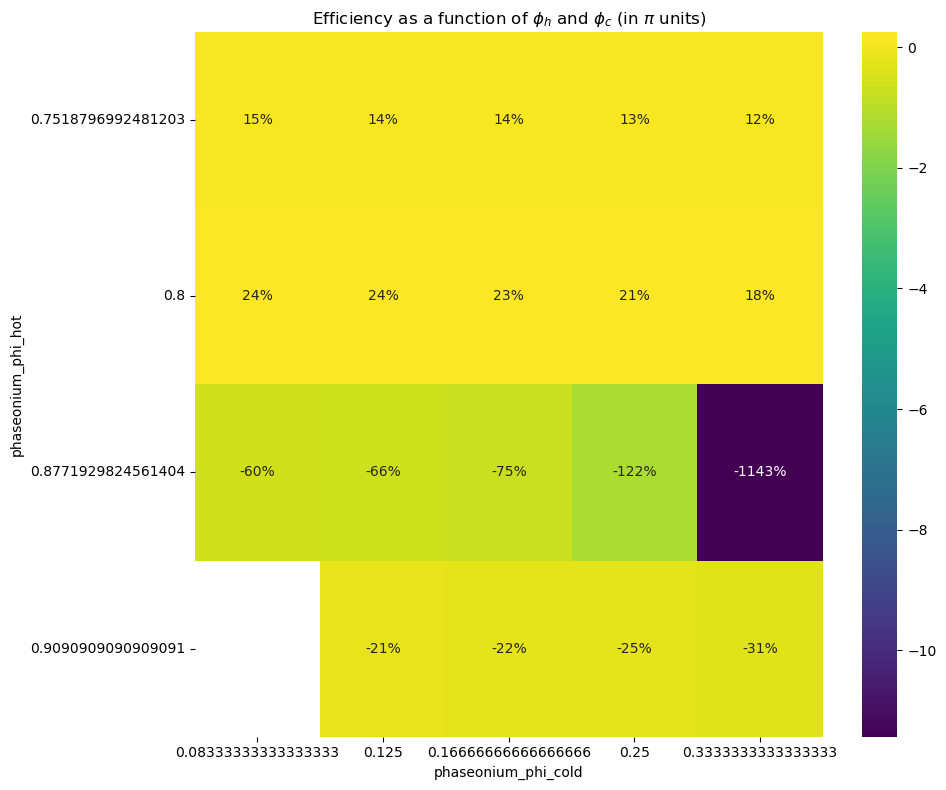

In [14]:
# Fix parameters
CLASSICAL_ETA_DEF = "CNCA"  # Chambadal–Novikov–Curzon–Ahlborn or Carnot efficiency
c1_force = 2.0
c2_force = 2.0
stroke_time = 1000000
filtered_df = df_simulations[
    (df_simulations.loc[:, ("cavity1", "compressing_force")] == c1_force) &
    (df_simulations.loc[:, ("cavity2", "compressing_force")] == c2_force) &
    (df_simulations.loc[:, ("stroke_time", "isochore")] == stroke_time) 
    # & (df_simulations.loc[:, ("output", "Carnot")] > 0)
]
filtered_df = filtered_df.reset_index()
filtered_df.columns = ['_'.join(col).strip() for col in filtered_df.columns.values]
filtered_df.loc[:, "gain"] = filtered_df["output_Efficiency"] / filtered_df[f"output_{CLASSICAL_ETA_DEF}"]
filtered_df.loc[:, "phaseonium_phi_hot"] = 1 / filtered_df.loc[:, "phaseonium_phi_hot"].values
filtered_df.loc[:, "phaseonium_phi_cold"] = 1 / filtered_df.loc[:, "phaseonium_phi_cold"].values
print(filtered_df.columns)
# Create a pivot table with X and Y as indices and Z as values
X = "phaseonium_phi_hot"
Y = "phaseonium_phi_cold"
Z = "gain"
pivot_table = filtered_df.pivot_table(index=X, columns=Y, values=Z)
names_table = filtered_df.pivot_table(index=X, columns=Y, values="meta_name", aggfunc=lambda x: ', '.join(x)).fillna("")

# For a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='.0%')
plt.title('Efficiency as a function of $\\phi_h$ and $\\phi_c$ (in $\\pi$ units)')
plt.tight_layout()
plt.show()

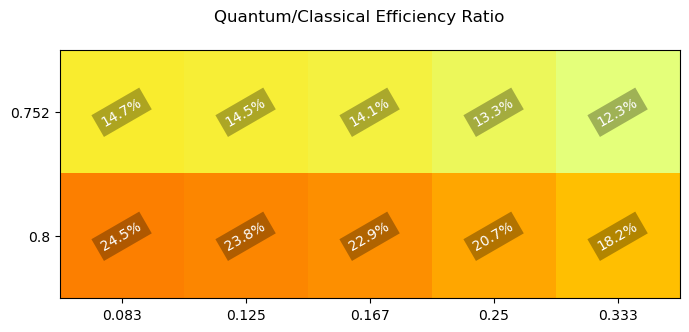

In [13]:
x = [round(i, 3) for i in pivot_table.columns]
y = [round(i, 3) for i in pivot_table.index]
y1 = pivot_table.values[0]
y1_label = f"$\\pi / {1/pivot_table.index[0]}$"
y2 = pivot_table.values[1]
y2_label = f"$\\pi / {1/pivot_table.index[1]}$"

Y = pivot_table.values
fig, ax = plt.subplots(figsize=(8, 3.4))
fig.suptitle("Quantum/Classical Efficiency Ratio")
im = ax.imshow(Y, cmap='Wistia')
# Create colorbar
# cbar = ax.figure.colorbar(im, ax=ax)
# cbar.ax.set_ylabel("Efficiency ratio", rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries.
ax.set_xticks(range(Y.shape[1]), labels=x)
ax.set_yticks(range(Y.shape[0]), labels=y)

# Let the horizontal axes labeling appear on top.
ax.tick_params(top=False, bottom=True,
                labeltop=False, labelbottom=True)

texts = []
kw = dict(horizontalalignment="center",
          verticalalignment="center", fontsize=10, color="white",
          rotation=30,
          bbox=dict(facecolor="black", alpha=0.3, edgecolor="none"))
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        value = round(Y[i][j] * 100, 1) 
        text = im.axes.text(j, i, f"{value}%", **kw)
        texts.append(text)

### Mutual Information

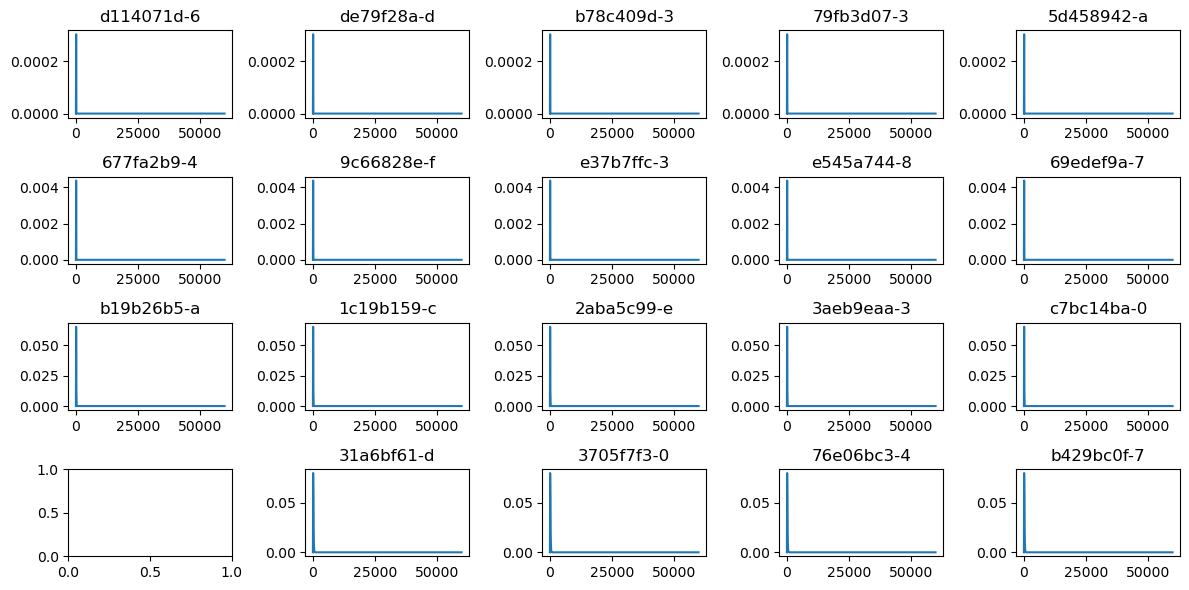

In [20]:
figures_layout = pivot_table = filtered_df.pivot_table(
    index="phaseonium_phi_hot", columns="phaseonium_phi_cold", values="meta_name", aggfunc=lambda x: ', '.join(x)).fillna("")
fig, axs = plt.subplots(*figures_layout.shape, figsize=(12, 6), layout='tight')

for i, row in enumerate(figures_layout.index):
    for j, col in enumerate(figures_layout.columns):
        f = ROOT / f"simulation_{figures_layout.iloc[i, j]}"
        if not f.exists():
            continue

        with gzip.open(f / "evolution_history.pkl.gz", "rb") as zipfile:
            mutinf = pickle.load(zipfile)["S"]["Mutual Information"]
        timesteps = np.load(f / "cascade_evolution_1cycle.npz").files
        
        ndims, alpha, surfaces, forces, sampling_times, stroke_times = read_configuration(f, timesteps)
    
        plot_observable(sampling_times, mutinf, stroke_times, ax=axs[i, j], title=figures_layout.iloc[i, j], grid=True)


In [21]:
phi_hot = 1.6
phi_cold = 1.8
df_slice = filtered_df[(filtered_df.loc[:, "phaseonium_phi_cold"] == phi_cold) & (filtered_df.loc[:, "phaseonium_phi_hot"] == phi_hot)]
print(f"Carnot Efficiency is {df_slice.loc[:, 'output_Carnot'].values[0]}")
T_hot = classic_temp(T_HOT, OMEGA, np.pi / phi_hot)
T_cold = classic_temp(T_COLD, OMEGA, np.pi / phi_cold)
print(f"That's because hot temperature is {T_hot} and cold temperature is {T_cold}")
print(1 - T_cold / T_hot)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [24]:
pivot_table.loc[1.6, 1.8]
print(pivot_table.columns.name)
print(pivot_table.index.name)

KeyError: 1.8

In [ ]:
filtered_df[filtered_df[("phaseonium_phi_hot")]==1.8]

UndefVarError: UndefVarError: `filtered_df` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
ldf = filtered_df.loc["b5b25531-c"]
phi_hot= ldf["phaseonium_phi_hot"]
phi_cold = ldf["phaseonium_phi_cold"]
T_hot_cl = classic_temp(T_HOT, OMEGA, np.pi/phi_hot)
T_cold_cl = classic_temp(T_COLD, OMEGA, np.pi/phi_cold)
print(phi_hot)
print(phi_cold)
print(T_hot_cl)
print(T_cold_cl)
1-T_cold_cl/T_hot_cl

UndefVarError: UndefVarError: `filtered_df` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [23]:
classic_temp(2.5, OMEGA, np.pi/1.8)

np.float64(2.282339385386267)

## Efficiency with time
Now we reduce the thermalization time to see how the efficiency rateo changes

In [ ]:
# Fix parameters
CLASSICAL_ETA_DEF = "CNCA"  # Chambadal–Novikov–Curzon–Ahlborn or Carnot efficiency
c1_force = 2.0
c2_force = 2.0
phi_cold = 12
phi_hot = 1.25
filtered_df = df_simulations[
    (df_simulations.loc[:, ("cavity1", "compressing_force")] == c1_force) 
    & (df_simulations.loc[:, ("cavity2", "compressing_force")] == c2_force) 
    & (df_simulations.loc[:, ("phaseonium", "phi_cold")] == phi_cold) 
    & (df_simulations.loc[:, ("phaseonium", "phi_hot")] == phi_hot) 
    & (df_simulations.loc[:, ("output", "Carnot")] > 0)
]
filtered_df = filtered_df.reset_index()
filtered_df.columns = ['_'.join(col).strip() for col in filtered_df.columns.values]
filtered_df.loc[:, "gain"] = filtered_df["output_Efficiency"] / filtered_df[f"output_{CLASSICAL_ETA_DEF}"]
filtered_df.loc[:, "phaseonium_phi_hot"] = 1 / filtered_df.loc[:, "phaseonium_phi_hot"].values
filtered_df.loc[:, "phaseonium_phi_cold"] = 1 / filtered_df.loc[:, "phaseonium_phi_cold"].values
print(filtered_df.columns)
# Create a pivot table with X and Y as indices and Z as values
X = "phaseonium_phi_hot"
Y = "phaseonium_phi_cold"
Z = "gain"
pivot_table = filtered_df.pivot_table(index=X, columns=Y, values=Z)
names_table = filtered_df.pivot_table(index=X, columns=Y, values="meta_name", aggfunc=lambda x: ', '.join(x)).fillna("")

# For a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='.0%')
plt.title('Efficiency as a function of $\\phi_h$ and $\\phi_c$ (in $\\pi$ units)')
plt.tight_layout()
plt.show()